# Preprocess drprnull 42D

In [1]:
!python --version

Python 3.12.2


## Load required packages 

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scvi
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


## Read 10x Cellranger 7 counts matrix as anndata 

In [4]:

## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
inputpath = basepath.joinpath('analysis','sctk_qc')
outputpath = basepath.joinpath('analysis','preprocess')
outputfile = basepath.joinpath('analysis','preprocess','drprnull_42D.h5ad')


In [5]:
## Read in count matrix
#drprnull_42d = sc.read_10x_mtx(
#    inputpath.joinpath('drprnull_42D','outs','filtered_feature_bc_matrix'),
#    var_names="gene_symbols",  
#    cache=True)

## Read sctk-qc h5ad 
drprnull_42d = sc.read_h5ad(inputpath.joinpath("drprnull_42d.h5ad"))
drprnull_42d.raw = drprnull_42d

drprnull_42d


AnnData object with n_obs × n_vars = 7674 × 16507
    obs: 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters'
    var: 'feature_ID', 'feature_name', 'feature_type'
    uns: 'X_name', 'assayType', 'runBcds', 'runCxds', 'runCxdsBcdsHybrid', 'runDoubletFinder', 'scater', 'scater_addPerCellQC', 'sctk'
    obsm: 'decontX_UMAP', 'doubletFinder_UMAP'
    layers: 'decontXcounts'

## Calculate qc metrics

In [6]:
drprnull_42d.var_names = drprnull_42d.var.feature_name
drprnull_42d.var_names_make_unique()

drprnull_42d.var["mt"] = drprnull_42d.var_names.str.startswith("mt:")
sc.pp.calculate_qc_metrics(
    drprnull_42d, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

In [7]:
drprnull_42d ## 7674 cells, 16507 genes 

AnnData object with n_obs × n_vars = 7674 × 16507
    obs: 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'feature_ID', 'feature_name', 'feature_type', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'X_name', 'assayType', 'runBcds', 'runCxds', 'runCxdsBcdsHybrid', 'runDoubletFinder', 'scater', 'scater_addPerCellQC', 'sctk'
    obsm: 'decontX_UMAP', 'doubletFinder_UMAP'
    layers: 'decontXcounts'

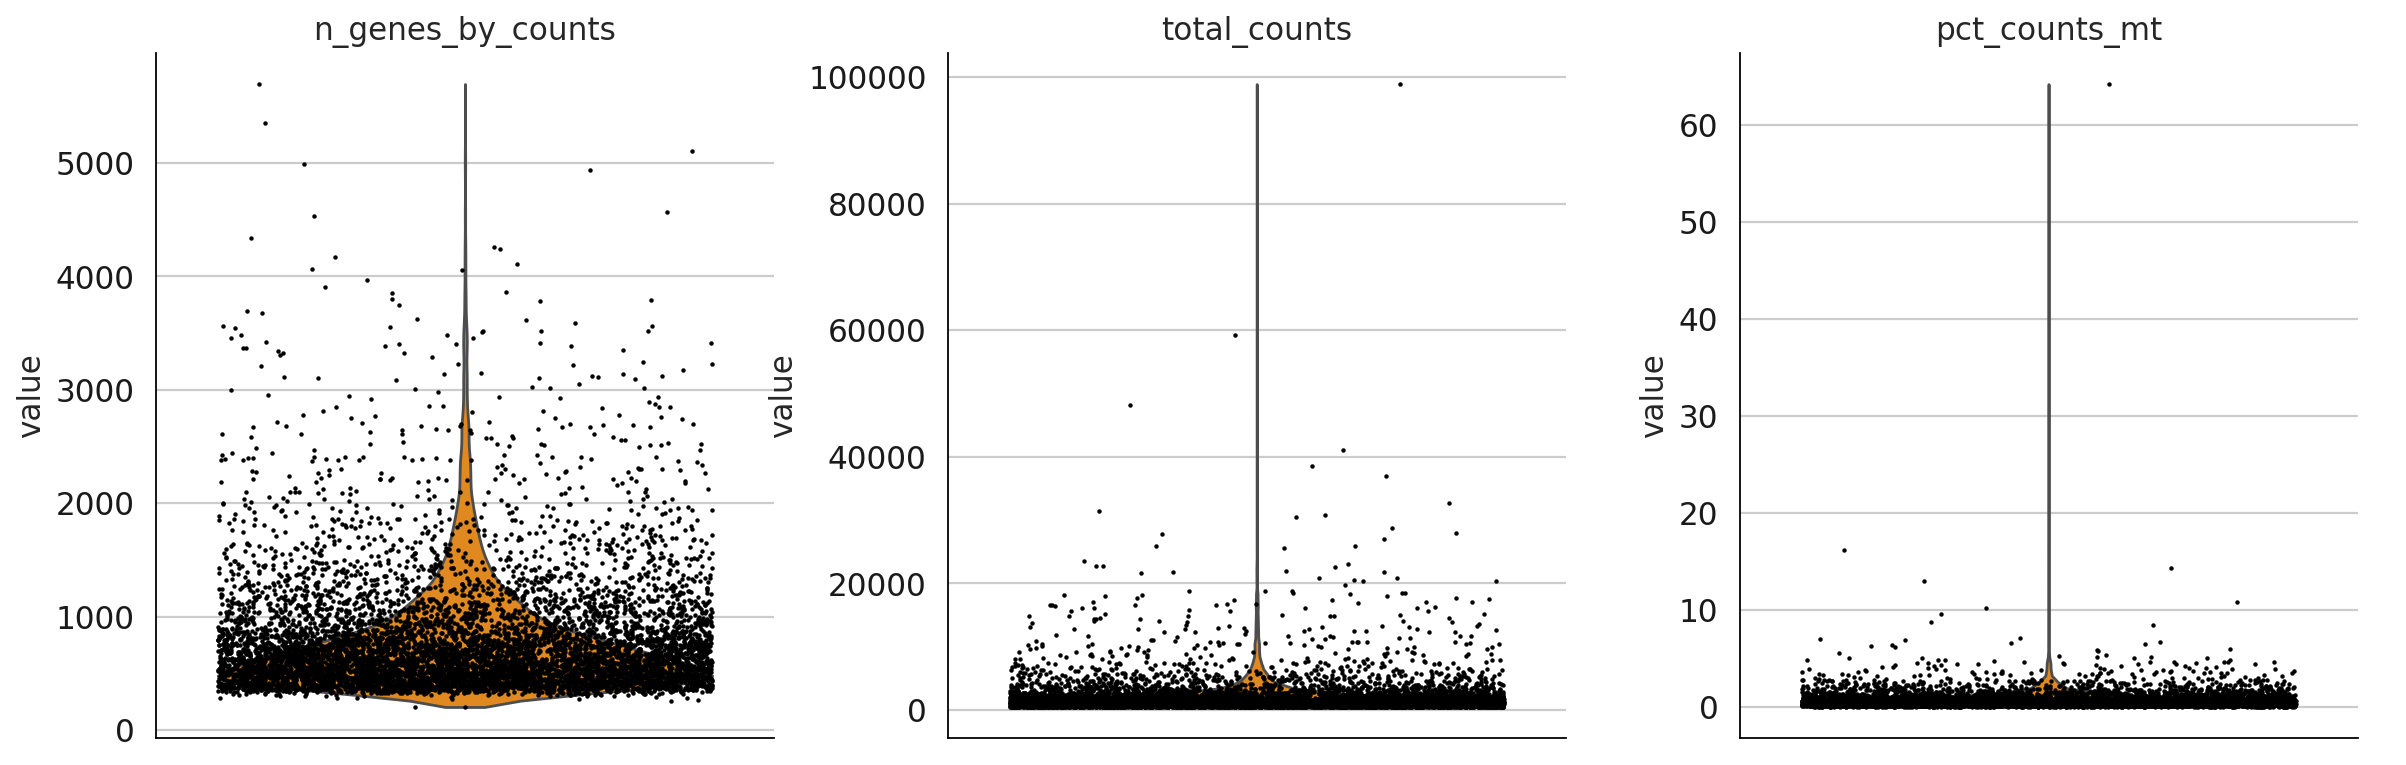

In [8]:
sc.pl.violin(
    drprnull_42d,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4, size=2,
    multi_panel=True,color="darkorange"
)


In [9]:
sc.pp.filter_cells(drprnull_42d, min_genes=200)
sc.pp.filter_genes(drprnull_42d, min_cells=3)

filtered out 4604 genes that are detected in less than 3 cells


## Proportion of total counts for a cell which are mitochondrial.

<Axes: xlabel='total_counts', ylabel='pct_counts_mt'>

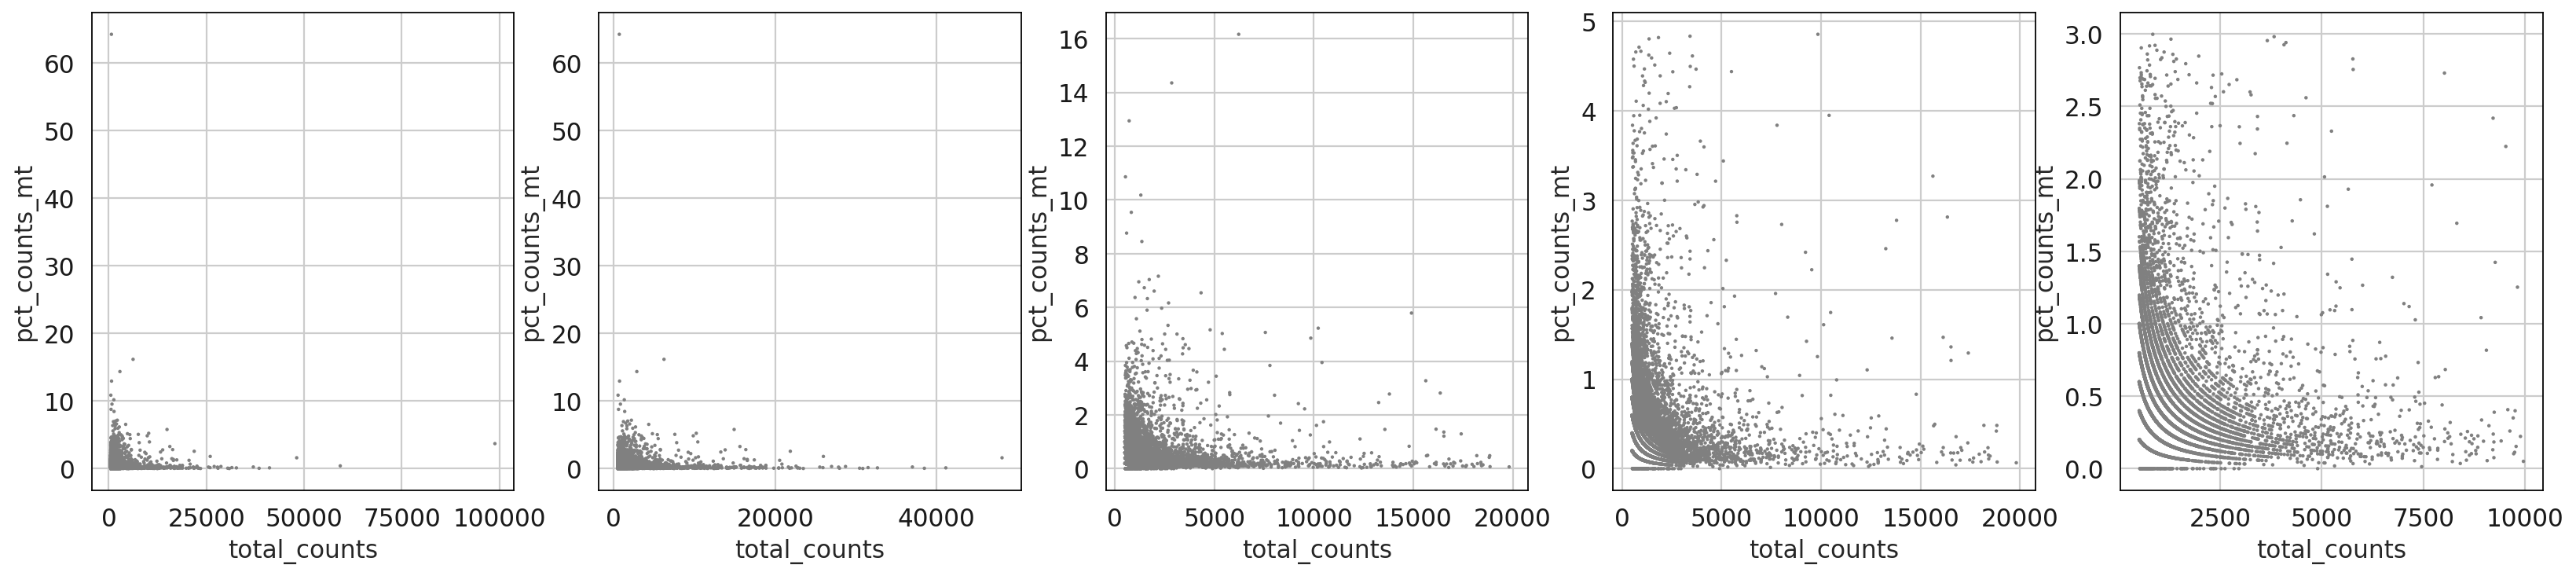

In [10]:
fig, axes = plt.subplots(1,5, figsize=(25,5))
sc.pl.scatter(drprnull_42d, x="total_counts", y="pct_counts_mt", show=False, ax=axes[0])
pct_counts_mt_filter = drprnull_42d[drprnull_42d.obs.total_counts < 50000, :].copy()
sc.pl.scatter(pct_counts_mt_filter, x="total_counts", y="pct_counts_mt", show=False, ax=axes[1])

pct_counts_mt_filter = drprnull_42d[drprnull_42d.obs.pct_counts_mt<20,:].copy()
pct_counts_mt_filter   = pct_counts_mt_filter[pct_counts_mt_filter.obs.total_counts < 20000, :].copy()
sc.pl.scatter(pct_counts_mt_filter, x="total_counts", y="pct_counts_mt", show=False, ax=axes[2])

pct_counts_mt_filter = drprnull_42d[drprnull_42d.obs.pct_counts_mt<5,:].copy()
pct_counts_mt_filter   = pct_counts_mt_filter[pct_counts_mt_filter.obs.total_counts < 20000, :].copy()
sc.pl.scatter(pct_counts_mt_filter, x="total_counts", y="pct_counts_mt", show=False, ax=axes[3])

pct_counts_mt_filter = drprnull_42d[drprnull_42d.obs.pct_counts_mt<3,:].copy()
pct_counts_mt_filter   = pct_counts_mt_filter[pct_counts_mt_filter.obs.total_counts < 10000, :].copy()
sc.pl.scatter(pct_counts_mt_filter, x="total_counts", y="pct_counts_mt", show=False, ax=axes[4])


## The number of genes with at least 1 count in a cell. Calculated for all cells.

<Axes: xlabel='total_counts', ylabel='n_genes_by_counts'>

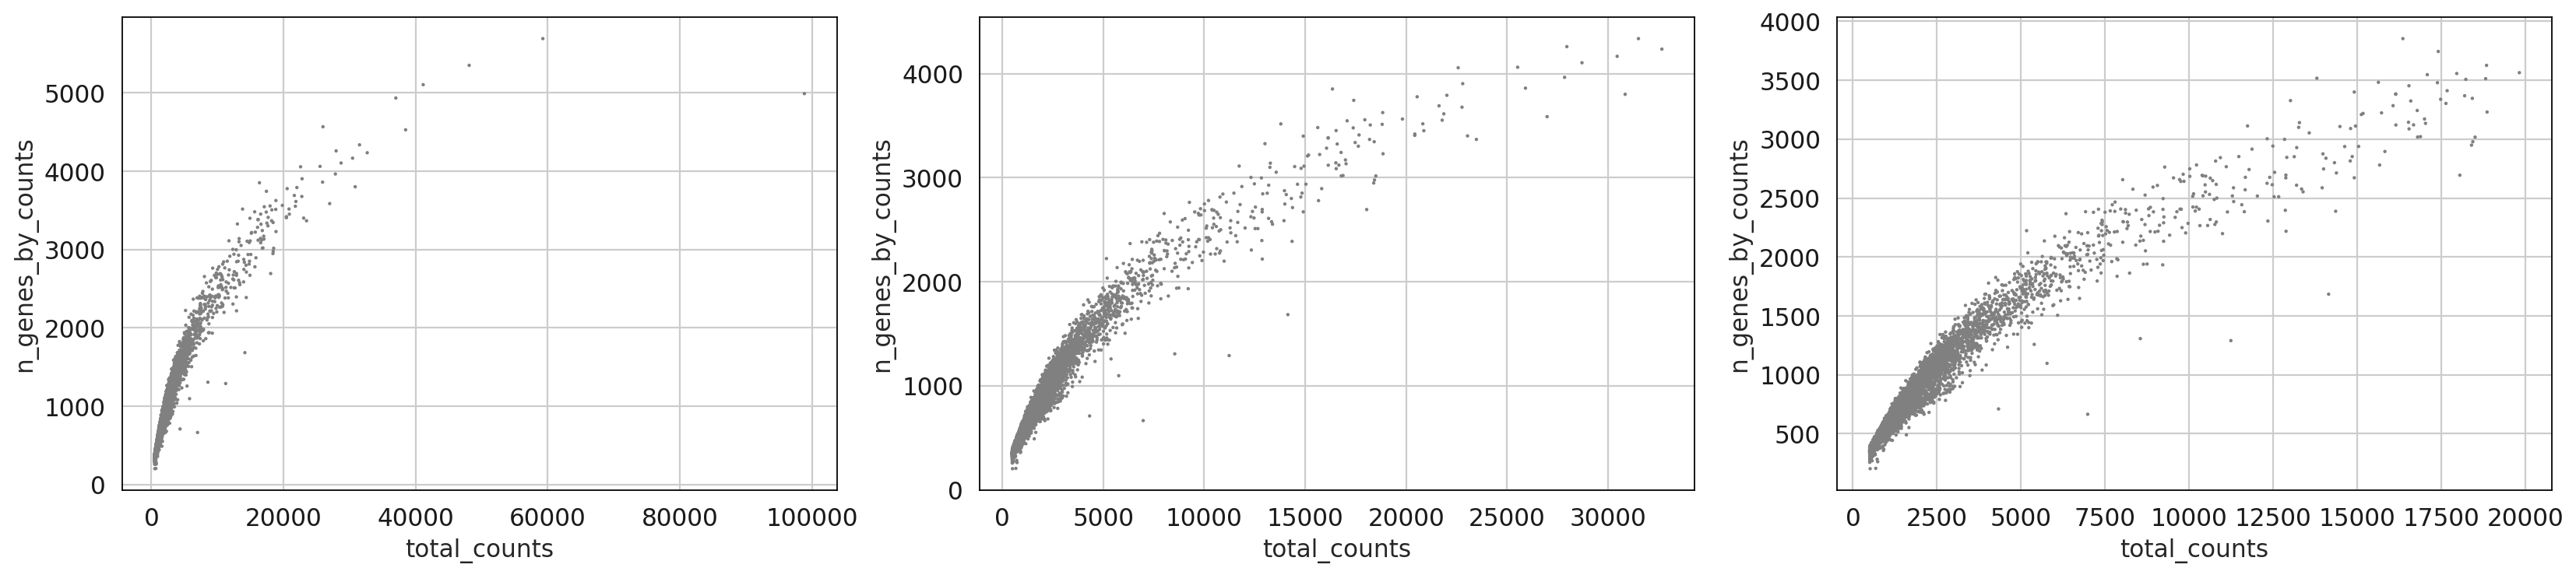

In [11]:
fig, axes = plt.subplots(1,3, figsize=(25,5))
sc.pl.scatter(drprnull_42d, x="total_counts", y="n_genes_by_counts", show=False, ax=axes[0])
ngeneslt4500 = drprnull_42d[drprnull_42d.obs.n_genes_by_counts < 4500, :] 
sc.pl.scatter(ngeneslt4500, x="total_counts", y="n_genes_by_counts", show=False, ax=axes[1])
ngeneslt4000_countslt2000 = drprnull_42d[drprnull_42d.obs.n_genes_by_counts < 4000, :] 
ngeneslt4000_countslt2000 = ngeneslt4000_countslt2000[ngeneslt4000_countslt2000.obs.total_counts < 20000, :] 
sc.pl.scatter(ngeneslt4000_countslt2000, x="total_counts", y="n_genes_by_counts", show=False, ax=axes[2])

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


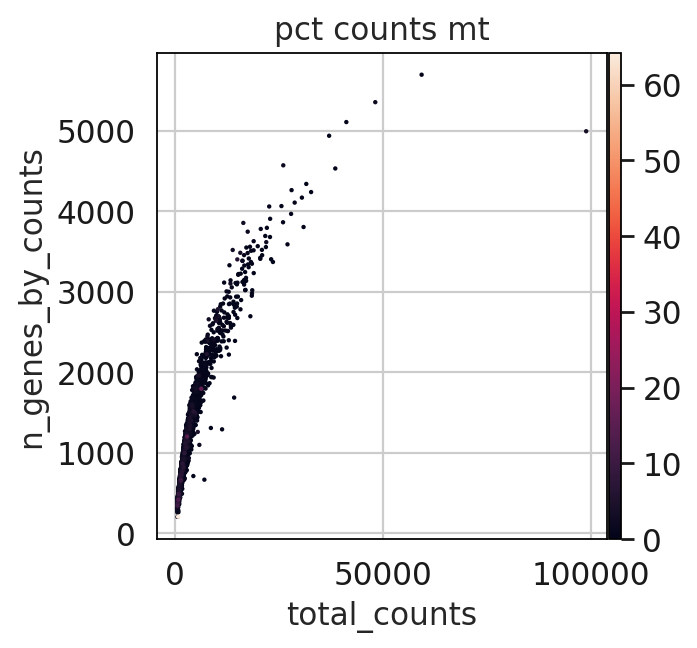

In [12]:
sc.pl.scatter(drprnull_42d, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Sum of counts for a gene.

Text(0.5, 1.0, 'Log1p Counts per gene')

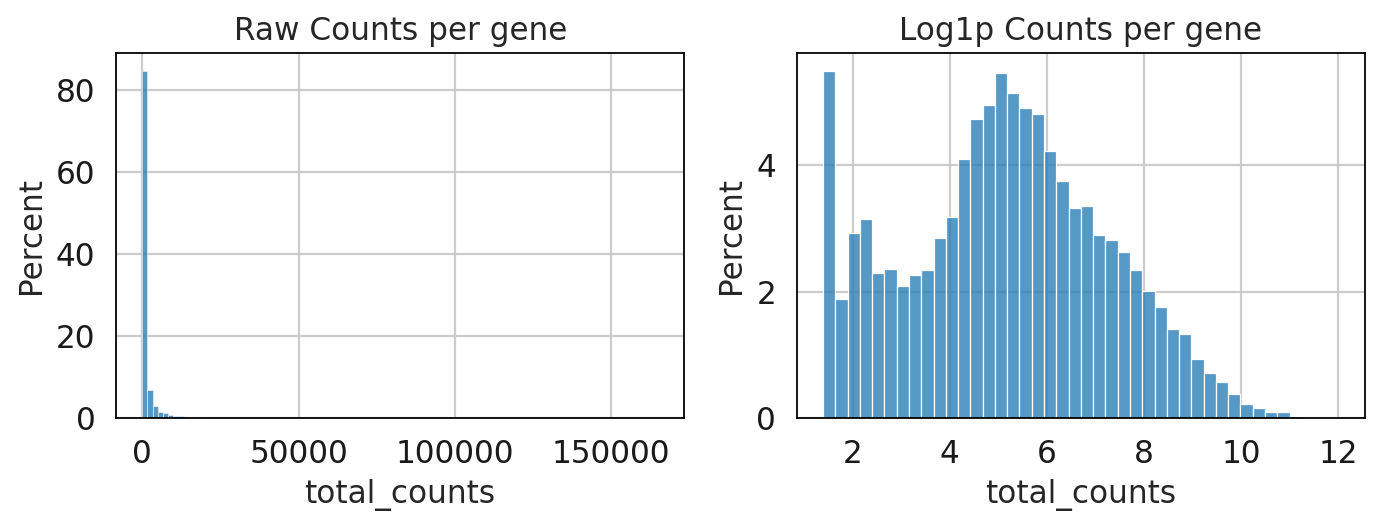

In [13]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
sns.histplot(drprnull_42d.var.total_counts, ax=ax[0],bins=100, stat="percent")
ax[0].set_title("Raw Counts per gene")
sns.histplot(np.log1p(drprnull_42d.var.total_counts), ax=ax[1],stat="percent")
ax[1].set_title("Log1p Counts per gene")

## Filter low quality reads

In [14]:
sc.pp.calculate_qc_metrics(
    drprnull_42d, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
drprnull_42d

AnnData object with n_obs × n_vars = 7674 × 11903
    obs: 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt'
    var: 'feature_ID', 'feature_name', 'feature_type', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts'
    uns: 'X_name', 'assayType', 'runBcds', 'runCxds', 'runCxdsBcdsHybrid', 'runDoubletFinder', 'scater', 'scater_addPerCellQC', 'sctk'
    obsm: 'decontX_UMAP', 'doubl

In [15]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

drprnull_42d.obs["outlier"] = (
    is_outlier(drprnull_42d, "log1p_total_counts", 5)
    | is_outlier(drprnull_42d, "log1p_n_genes_by_counts", 5)
    | is_outlier(drprnull_42d, "pct_counts_in_top_20_genes", 5)
)
drprnull_42d.obs.outlier.value_counts()

outlier
False    7296
True      378
Name: count, dtype: int64

In [16]:
drprnull_42d.obs["mt_outlier"] = is_outlier(drprnull_42d, "pct_counts_mt", 3) | (
    drprnull_42d.obs["pct_counts_mt"] > 8
)
drprnull_42d.obs.mt_outlier.value_counts()

mt_outlier
False    6651
True     1023
Name: count, dtype: int64

In [17]:
print(f"Total number of cells: {drprnull_42d.n_obs}")
drprnull_42d = drprnull_42d[(~drprnull_42d.obs.outlier) & (~drprnull_42d.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {drprnull_42d.n_obs}")
drprnull_42d

Total number of cells: 7674
Number of cells after filtering of low quality cells: 6328


AnnData object with n_obs × n_vars = 6328 × 11903
    obs: 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'outlier', 'mt_outlier'
    var: 'feature_ID', 'feature_name', 'feature_type', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'log1p_mean_counts', 'log1p_total_counts'
    uns: 'X_name', 'assayType', 'runBcds', 'runCxds', 'runCxdsBcdsHybrid', 'runDoubletFinder', 'scater', 'scater_addPerCellQC', 'sctk'
    obs

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq/lib/python3.12/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


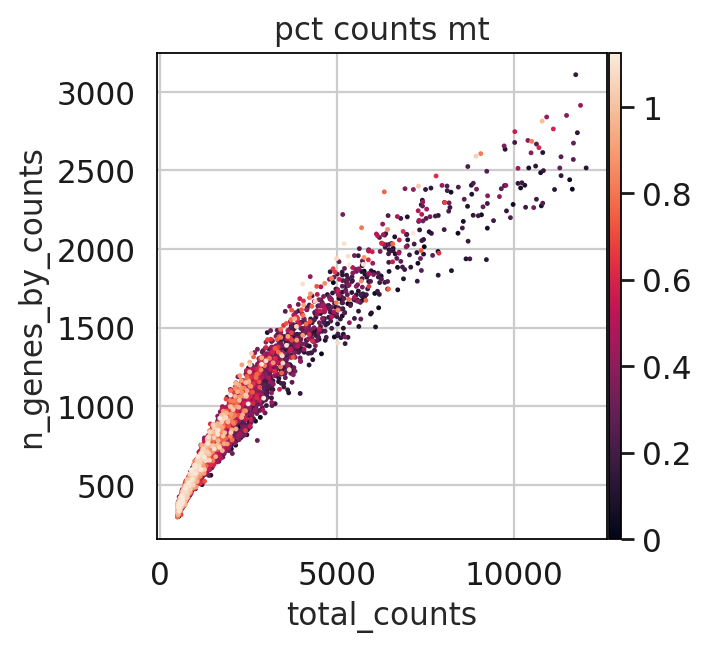

In [18]:
sc.pl.scatter(drprnull_42d, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [19]:
#drprnull_42d = drprnull_42d[drprnull_42d.obs.n_genes_by_counts < 2500, :] 
#drprnull_42d   = drprnull_42d[drprnull_42d.obs.pct_counts_mt <3,:].copy()
#drprnull_42d   = drprnull_42d[drprnull_42d.obs.total_counts <10000,:].copy()

## Ambient RNA & Doublets


<Axes: xlabel='scds_hybrid_score', ylabel='Percent'>

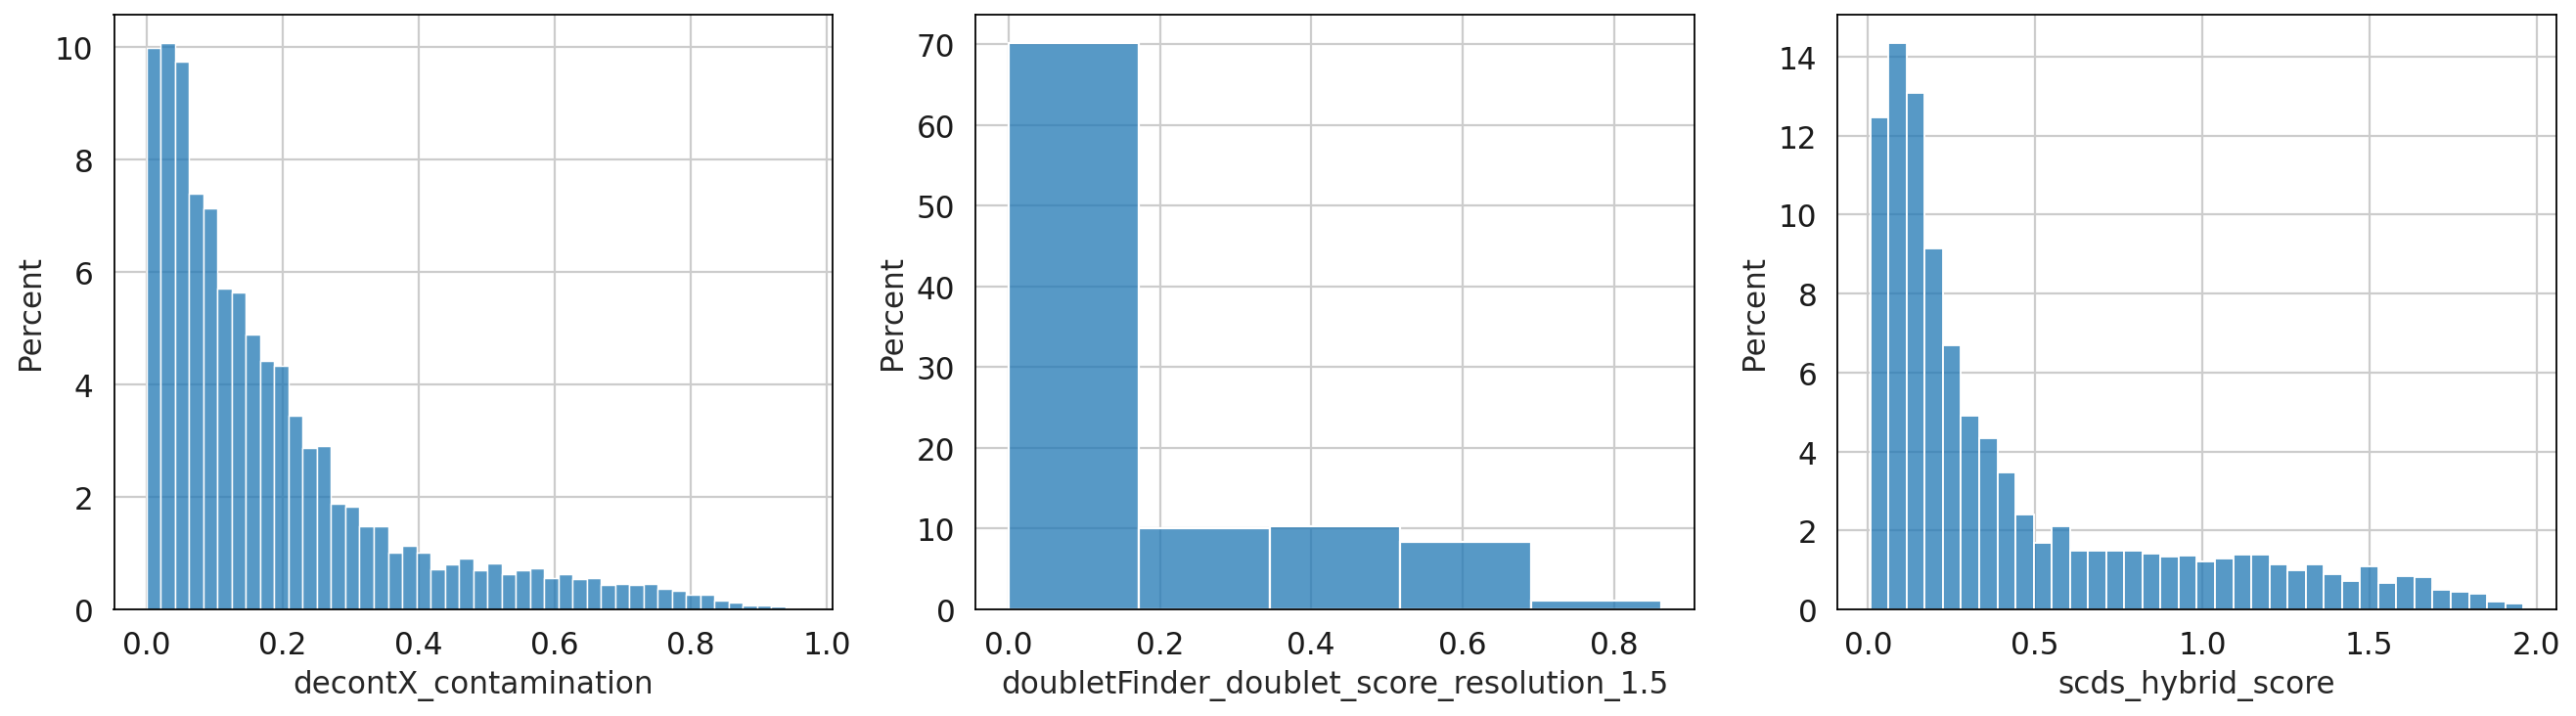

In [20]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.histplot(drprnull_42d.obs['decontX_contamination'], stat="percent", ax=ax[0])
sns.histplot(drprnull_42d.obs['doubletFinder_doublet_score_resolution_1.5'], stat="percent", ax=ax[1], bins=5)
sns.histplot(drprnull_42d.obs['scds_hybrid_score'], stat="percent", ax=ax[2])


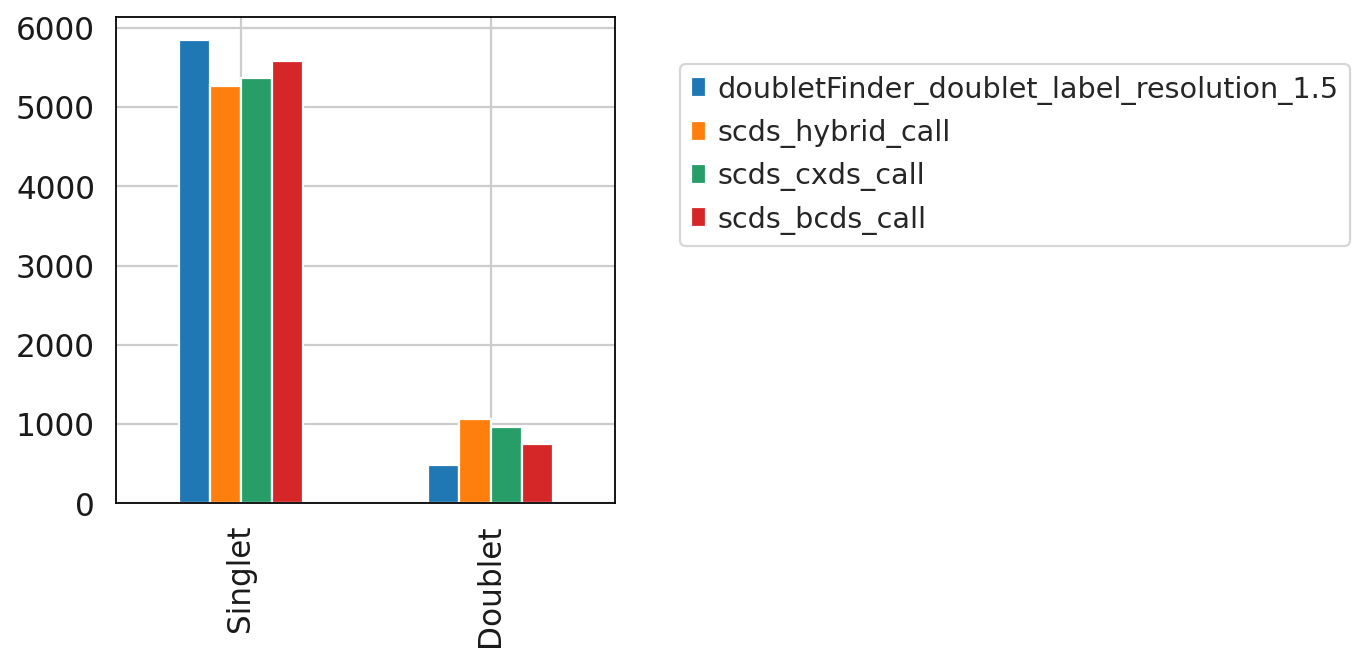

In [21]:
doublets = drprnull_42d.obs[['doubletFinder_doublet_label_resolution_1.5','scds_hybrid_call','scds_cxds_call','scds_bcds_call']].apply(pd.Series.value_counts)
doublets.plot(kind='bar')
plt.legend(loc='lower right', bbox_to_anchor=(2.5, 0.5))
##leave identified doublets in the dataset for now and inspect doublets during visualization later

In [22]:
## Make decontX corrected count matrix as the default
drprnull_42d.layers["rawcounts"] = drprnull_42d.X ## save raw counts 
drprnull_42d.X = drprnull_42d.layers['decontXcounts']

In [23]:
drprnull_42d.write(outputfile)